<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/ML_1M%20-%20tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import os 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
PATH_DIR = '/content/drive/MyDrive/Colab Notebooks/RecSys/movielens_datasets/ml-1m/'

# Data Processing

In [108]:
# Specify User's Age and Occupation Column
AGES = { 
    1: "Under 18", 
    18: "18-24", 
    25: "25-34", 
    35: "35-44", 
    45: "45-49", 
    50: "50-55", 
    56: "56+"
    }

OCCUPATIONS = { 
    0: "other or not specified", 
    1: "academic/educator", 
    2: "artist", 
    3: "clerical/admin",
    4: "college/grad student", 
    5: "customer service", 
    6: "doctor/health care",
    7: "executive/managerial", 
    8: "farmer", 
    9: "homemaker", 
    10: "K-12 student", 
    11: "lawyer",
    12: "programmer", 
    13: "retired", 
    14: "sales/marketing", 
    15: "scientist", 
    16: "self-employed",
    17: "technician/engineer", 
    18: "tradesman/craftsman", 
    19: "unemployed", 
    20: "writer" 
    }

# Define csv files to be saved into
USERS_CSV_FILE = 'users2.csv'
MOVIES_CSV_FILE = 'movies.csv'
RATINGS_CSV_FILE = 'ratings.csv'

# ======================
#        Ratings 
# ======================
ratings = pd.read_csv(
    os.path.join(PATH_DIR, PATH_DIR+'ratings.dat'), 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['user_id', 'movie_id', 'rating', 'timestamp']
    )

# Set max_userid to the maximum user_id in the ratings
max_userid = ratings['user_id'].drop_duplicates().max()

# Set max_movieid to the maximum movie_id in the ratings
max_movieid = ratings['movie_id'].drop_duplicates().max()

# Process ratings dataframe for Deep Learning model add user_emb_id column whose values == user_id - 1
ratings['user_emb_id'] = ratings['user_id'] - 1

# Add movie_emb_id column whose values == movie_id - 1
ratings['movie_emb_id'] = ratings['movie_id'] - 1

print(len(ratings), 'ratings loaded')

# Save into ratings.csv
ratings.to_csv(
    os.path.join(PATH_DIR, RATINGS_CSV_FILE), 
    sep='\t', 
    header=True, 
    encoding='latin-1', 
    columns=['user_id', 'movie_id', 'rating', 'timestamp', 'user_emb_id', 'movie_emb_id']
    )
print('Saved to', os.path.join(PATH_DIR, RATINGS_CSV_FILE))

# ======================
#         Users
# ======================
users = pd.read_csv(
    os.path.join(PATH_DIR, 'users.dat'), 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['user_id', 'gender', 'age', 'occupation', 'zipcode']
    )
users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])

print(len(users), 'descriptions of', max_userid, 'users loaded.')

# Save into users.csv
users.to_csv(
    os.path.join(PATH_DIR, USERS_CSV_FILE), 
    sep='\t', 
    header=True, 
    encoding='latin-1',
    columns=['user_id', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc']
    )

print('Saved to', os.path.join(PATH_DIR, USERS_CSV_FILE))

# Read the Movies File
movies = pd.read_csv(
    os.path.join(PATH_DIR, 'movies.dat'), 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['movie_id', 'title', 'genres']
    )

print(len(movies), 'descriptions of', max_movieid, 'movies loaded.')

# Save into movies.csv
movies.to_csv(
    os.path.join(PATH_DIR, USERS_CSV_FILE), 
    sep='\t', 
    header=True, 
    columns=['movie_id', 'title', 'genres']
    )

print('Saved to', os.path.join(PATH_DIR, MOVIES_CSV_FILE))

1000209 ratings loaded
Saved to /content/drive/MyDrive/Colab Notebooks/RecSys/movielens_datasets/ml-1m/ratings.csv
6040 descriptions of 6040 users loaded.
Saved to /content/drive/MyDrive/Colab Notebooks/RecSys/movielens_datasets/ml-1m/users2.csv
3883 descriptions of 3952 movies loaded.
Saved to /content/drive/MyDrive/Colab Notebooks/RecSys/movielens_datasets/ml-1m/movies.csv


# Movie Recommendation with Content-Based and Collaborative Filtering
“*What movie should I watch this evening?*” 

Have you ever had to answer this question at least once when you came home from work? As for me — yes, and more than once. From Netflix to Hulu, the need to build robust movie recommendation systems is extremely important given the huge demand for personalized content of modern consumers.

An example of recommendation system is such as this:
* User A watches **Game of Thrones** and **Breaking Bad**.
* User B does search on **Game of Thrones**, then the system suggests **Breaking Bad** from data collected about user A.

Recommendation systems are used not only for movies, but on multiple other products and services like Amazon (Books, Items), Pandora/Spotify (Music), Google (News, Search), YouTube (Videos) etc.

<img src="https://drive.google.com/uc?id=1rpmmEiLa9qtFyoxOBJYFHSoWG6eZ0sFr" alt="drawing" width="500"/>

Two most ubiquitous types of personalized recommendation systems are **Content-Based** and **Collaborative Filtering**. Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In this notebook, I will attempt at implementing these two systems to recommend movies and evaluate them to see which one performs better.

After reading this post you will know:

* About the MovieLens dataset problem for recommender system.
* How to load and process the data.
* How to do exploratory data analysis.
* The 2 different types of recommendation engines.
* How to develop a content-based recommendation model based on movie genres.
* How to develop a collaborative filtering model based on user ratings.
* Alternative approach to improve existing models.

Let’s get started.

## The MovieLens Dataset
One of the most common datasets that is available on the internet for building a Recommender System is the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). This version of the dataset that I'm working with ([1M](https://grouplens.org/datasets/movielens/1m/)) contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The data was collected by GroupLens researchers over various periods of time, depending on the size of the set. This 1M version was released on February 2003. Users were selected at random for inclusion. All users selected had rated at least 20 movies. Each user is represented by an id, and no other information is provided.

The original data are contained in three files, [movies.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/movies.dat), [ratings.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/ratings.dat) and [users.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/users.dat). To make it easier to work with the data, I converted them into csv files. The process can be viewed in my [Data Processing Notebook](https://github.com/khanhnamle1994/movielens/blob/master/Data_Processing.ipynb).

<img src="https://drive.google.com/uc?id=1zWdNvVWosoihXotr2T8MlyOUrYJowKS6" alt="drawing" width="500"/>

## Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **movies**. Before that, I'll also pass in column names for each CSV and read them using pandas (the column names are available in the [Readme](https://github.com/khanhnamle1994/movielens/blob/master/README.md) file).

In [37]:
ratings = ratings[['user_id', 'movie_id', 'rating']]
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [39]:
users = users[['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc']]
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


In [40]:
movies = movies[['movie_id', 'title', 'genres']]
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Now lets take a peak into the content of each file to understand them better.

### Ratings Dataset

In [45]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1000209 non-null  int64
 1   movie_id  1000209 non-null  int64
 2   rating    1000209 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


This confirms that there are 1M ratings for different user and movie combinations.

### Users Dataset

In [46]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   6040 non-null   int64 
 1   gender    6040 non-null   object
 2   zipcode   6040 non-null   object
 3   age_desc  6040 non-null   object
 4   occ_desc  6040 non-null   object
dtypes: int64(1), object(4)
memory usage: 236.1+ KB


This confirms that there are 6040 users and we have 5 features for each (unique user ID, gender, age, occupation and the zip code they are living in).

### Movies Dataset

In [47]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


This dataset contains attributes of the 3883 movies. There are 3 columns including the movie ID, their titles, and their genres. Genres are pipe-separated and are selected from 18 genres (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western).

## Data Exploration
### Titles
Are there certain words that feature more often in Movie Titles? I'll attempt to figure this out using a word-cloud visualization.

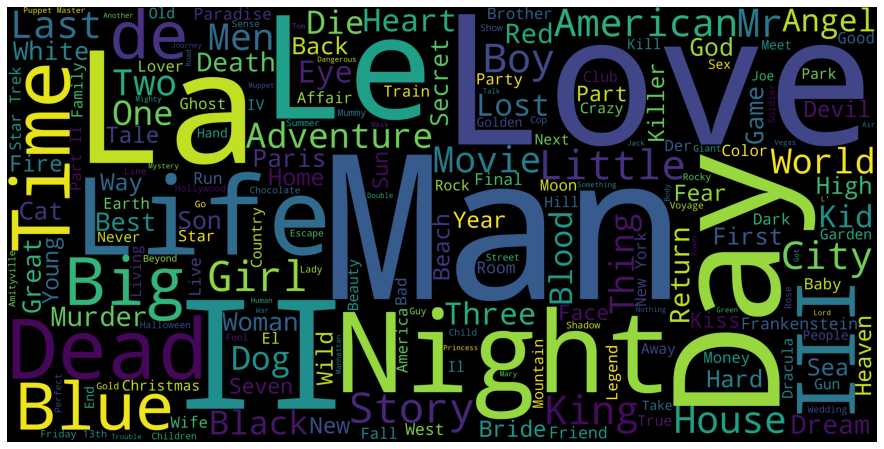

In [48]:
# Import new libraries
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Beautiful, isn't it? I can recognize that there are a lot of movie franchises in this dataset, as evidenced by words like *II* and *III*... In addition to that, *Day*, *Love*, *Life*, *Time*, *Night*, *Man*, *Dead*, *American* are among the most commonly occuring words.

### Ratings
Next I want to examine the **rating** further. Let's take a look at its summary statistics and distribution.

In [49]:
# Get summary statistics of rating
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


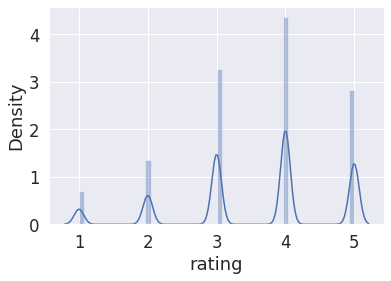

In [51]:
import seaborn as sns

sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

It appears that users are quite generous in their ratings. The mean rating is 3.58 on a scale of 5. Half the movies have a rating of 4 and 5. I personally think that a 5-level rating skill wasn’t a good indicator as people could have different rating styles (i.e. person A could always use 4 for an average movie, whereas person B only gives 4 out for their favorites). Each user rated at least 20 movies, so I doubt the distribution could be caused just by chance variance in the quality of movies.

Let's also take a look at a subset of 20 movies with the highest rating.

In [52]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies, ratings),users)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5
489237,Rushmore (1998),Comedy,5
489236,"Simple Plan, A (1998)",Crime|Thriller,5
489226,Hands on a Hard Body (1996),Documentary,5
489224,Pleasantville (1998),Comedy,5
489212,Say Anything... (1989),Comedy|Drama|Romance,5


### Genres
The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [53]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471]]

The top 5 genres are, in that respect order: Drama, Comedy, Action, Thriller, and Romance. I'll show this on a wordcloud too in order to make it more visually appealing.

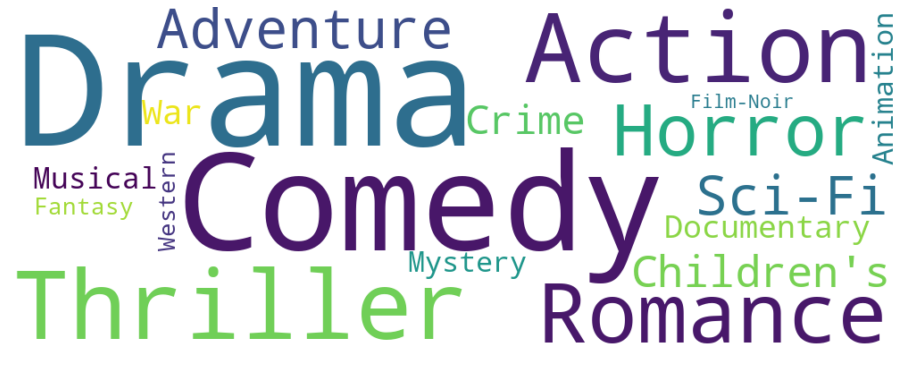

In [54]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Types of Recommendation Engines

### 1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

### 2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. 

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.

<img src="https://drive.google.com/uc?id=1YmyOjOfFIPjfglNtolbFL68q0GnBz5_v" alt="drawing" width="500"/>

## Content-Based Recommendation Model
### Theory
The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “**the results of latest European Socccer games**” on Google. It is certain that “**the**” will occur more frequently than “**soccer games**” but the relative importance of **soccer games** is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Below is the equation to calculate the TF-IDF score:

<img src="https://drive.google.com/uc?id=1lw0i0ZkQCjfGLOI3cIvJch03wRuIqom1" alt="drawing" width="500"/>

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the **Vector Space Model** which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an **n-dimensional space** and the angles between the vectors are calculated to **determine the similarity between the vectors**. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.

<img src="https://drive.google.com/uc?id=1zbUGUUbASN4ARIudiRJiw7C5M0-SWh4P" alt="drawing" width="500"/>


Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the **value of cosine will increase with decreasing value of the angle** between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

### Implementation
With all that theory in mind, I am going to build a Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre. To do so, I will make use of the file **movies.csv**.

In [55]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use **TfidfVectorizer** function from **scikit-learn**, which transforms text to feature vectors that can be used as input to estimator.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

I will be using the **[Cosine Similarity](https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html)** to calculate a numeric quantity that denotes the similarity between two movies. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [57]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

I now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [58]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Let's try and get the top recommendations for a few movies and see how good the recommendations are.

In [59]:
genre_recommendations('Good Will Hunting (1997)').head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

In [60]:
genre_recommendations('Toy Story (1995)').head(20)

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [61]:
genre_recommendations('Saving Private Ryan (1998)').head(20)

461            Heaven & Earth (1993)
1204        Full Metal Jacket (1987)
1214     Boat, The (Das Boot) (1981)
1222                    Glory (1989)
1545                G.I. Jane (1997)
1959      Saving Private Ryan (1998)
2358       Thin Red Line, The (1998)
2993         Longest Day, The (1962)
3559            Flying Tigers (1942)
3574    Fighting Seabees, The (1944)
3585    Guns of Navarone, The (1961)
3684             Patriot, The (2000)
40                Richard III (1995)
153            Beyond Rangoon (1995)
332         Walking Dead, The (1995)
523          Schindler's List (1993)
641        Courage Under Fire (1996)
967          Nothing Personal (1995)
979           Michael Collins (1996)
1074                  Platoon (1986)
Name: title, dtype: object

As you can see, I have quite a decent list of recommendation for **Good Will Hunting** (Drama), **Toy Story** (Animation, Children's, Comedy), and **Saving Private Ryan** (Action, Thriller, War).

Overall, here are the pros of using content-based recommendation:
* No need for data on other users, thus no cold-start or sparsity problems.
* Can recommend to users with unique tastes.
* Can recommend new & unpopular items.
* Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

However, there are some cons of using this approach:
* Finding the appropriate features is hard.
* Does not recommend items outside a user's content profile.
* Unable to exploit quality judgments of other users.

## Collaborative Filtering Recommendation Model
The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, I will use Memory-Based Collaborative Filtering to make recommendations to movie users. The technique is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

### Theory
There are 2 main types of memory-based collaborative filtering algorithms:
1. **User-User Collaborative Filtering**: Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.
2. **Item-Item Collaborative Filtering**: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

<img src="https://drive.google.com/uc?id=1UoLFGLrpeEd0Mdsu_j-sE4n_tla_Xwuk" alt="drawing" width="500"/>

In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the **user-similarity matrix** will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the **item-similarity matrix** will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:
1. **Jaccard Similarity**:
    * Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B
    * It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked

2. **Cosine Similarity**: (as in the Content-Based system)
    * Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
    * Closer the vectors, smaller will be the angle and larger the cosine

3. **Pearson Similarity**:
    * Similarity is the pearson coefficient between the two vectors.

For the purpose of diversity, I will use **Pearson Similarity** in this implementation.

### Implementation
I will use the file **ratings.csv** first as it contains User ID, Movie IDs and Ratings. These three elements are all I need for determining the similarity of the users based on their ratings for a particular movie.

First I do some quick data processing:

In [63]:
# Fill NaN values in user_id and movie_id column with 0
ratings = ratings.assign(user_id = ratings['user_id'].fillna(0))
ratings = ratings.assign(movie_id = ratings['movie_id'].fillna(0))

# Replace NaN values in rating column with average of all values
ratings = ratings.assign(rating = ratings['rating'].fillna(ratings['rating'].mean()))

Due to the limited computing power in my laptop, I will build the recommender system using only a subset of the ratings. In particular, I will take a random sample of 20,000 ratings (2%) from the 1M ratings.

In [64]:
# Randomly sample 1% of the ratings dataset
small_data = ratings.sample(frac=0.02)
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 509567 to 606808
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   20004 non-null  int64
 1   movie_id  20004 non-null  int64
 2   rating    20004 non-null  int64
dtypes: int64(3)
memory usage: 625.1 KB
None


Now I use the **scikit-learn library** to split the dataset into testing and training.  **Cross_validation.train_test_split** shuffles and splits the data into two datasets according to the percentage of test examples, which in this case is 0.2.

In [67]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(small_data, test_size=0.2)

Now I need to create a user-item matrix. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.

In [71]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data[['user_id', 'movie_id', 'rating']].values
test_data_matrix = test_data[['user_id', 'movie_id', 'rating']].values

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(16003, 3)
(4001, 3)


Now I use the **pairwise_distances** function from sklearn to calculate the [Pearson Correlation Coefficient](https://stackoverflow.com/questions/1838806/euclidean-distance-vs-pearson-correlation-vs-cosine-similarity). This method provides a safe way to take a distance matrix as input, while preserving compatibility with many other algorithms that take a vector array.

In [72]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1.         0.41494973 0.96311897 0.99989616]
 [0.41494973 1.         0.15482877 0.40179529]
 [0.96311897 0.15482877 1.         0.9668965 ]
 [0.99989616 0.40179529 0.9668965  1.        ]]


In [73]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.01552119  0.01093952]
 [-0.01552119  1.         -0.06194848]
 [ 0.01093952 -0.06194848  1.        ]]


With the similarity matrix in hand, I can now predict the ratings that were not included with the data. Using these predictions, I can then compare them with the test data to attempt to validate the quality of our recommender model.

For the user-user CF case, I will look at the similarity between 2 users (A and B, for example) as weights that are multiplied by the ratings of a similar user B (corrected for the average rating of that user). I also need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that I am trying to predict. The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. 

In [74]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

### Evaluation
There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is **Root Mean Squared Error (RMSE)**. I will use the **mean_square_error (MSE)** function from sklearn, where the RMSE is just the square root of MSE.

$$\mathit{RMSE} =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}$$

I'll use the scikit-learn's **mean squared error** function as my validation metric. Comparing user- and item-based collaborative filtering, it looks like user-based collaborative filtering gives a better result.

In [75]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [76]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1431.2231146670133
Item-based CF RMSE: 1656.6407310624386


In [77]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 697.0416824777826
Item-based CF RMSE: 143.56167566871565


RMSE of training of model is a metric which measure how much the signal and the noise is explained by the model. I noticed that my RMSE is quite big. I suppose I might have overfitted the training data.

Overall, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

* It doesn't address the well-known cold-start problem, that is when new user or new item enters the system. 
* It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
* It suffers when new users or items that don't have any ratings enter the system.
* It tends to recommend popular items.

## Alternative Approach
As I mentioned above, it looks like my Collaborative Filtering model suffers from overfitting problem as I only train it on a small sample dataset (2% of the actual 1M ratings). In order to deal with this, I need to apply dimensionality reduction techniques to capture more signals from the big dataset. Thus comes the use of **low-dimensional factor models (aka, Model-Based Collaborative Filtering)**. I won't be able to implement this approach in this notebook due to computing limit, however, I want to introduce it here to give you a general sense of its advantages.

In this approach, CF models are developed using machine learning algorithms to predict user’s rating of unrated items. It has been shown that Model-based Collaborative Filtering has received greater exposure in industry research, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. An example is the competition to win the [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize), which used the best collaborative filtering algorithm to predict user ratings for films, based on previous ratings without any other information about the users or films.

Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. As per my understanding, the algorithms in this approach can further be broken down into 3 sub-types:

* **Matrix Factorization (MF)**: The idea behind such models is that attitudes or preferences of a user can be determined by a small number of hidden latent factors. These factors are also called **Embeddings**, which represent different characteristics for users and items. Matrix factorization can be done by various methods including Support Vecot Decomposition (SVD), Probabilistic Matrix Factorization (PMF), and Non-Negative Matrix Factorization (NMF).

* **Clustering based algorithm (KNN)**: The idea of clustering is same as that of memory-based recommendation systems. In memory-based algorithms, we use the similarities between users and/or items and use them as weights to predict a rating for a user and an item. The difference is that the similarities in this approach are calculated based on an unsupervised learning model, rather than Pearson correlation or cosine similarity.

* **Neural Nets / Deep Learning**: The idea of using Neural Nets is similar to that of Model-Based Matrix Factorization. In matrix factorizaion, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices. For neural net implementation, we don’t need them to be orthogonal, we want our model to learn the values of embedding matrix itself. The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm (Adam, SGD, etc.).

<img src="https://drive.google.com/uc?id=1DPzS3vc0KSdgDZnVGF__ZXdTHp0x-8zq" alt="drawing" width="500"/>


## Summary
In this post, I introduced the Movie Lens dataset for building movie recommendation system.

Specifically, I have developed recommendation models including:

* How to load and review the data.
* How to develop a content-based recommendation model based on movie genres.
* How to develop a memory-based collaborative filtering model based on user ratings.
* A glimpse at model-based collaborative filtering models as alternative options.

# SVD for Movie Recommendations
In this notebook, I'll detail a basic version of model-based collaborative filtering for recommendations by employing it on the MovieLens 1M dataset. 

[In my previous attempt](https://github.com/khanhnamle1994/movielens/blob/master/Content_Based_and_Collaborative_Filtering_Models.ipynb), I used user-based and item-based collaborative filtering to make movie recommendations from users' ratings data. I can only try them on a very small data sample (20,000 ratings), and ended up getting pretty high Root Mean Squared Error (bad recommendations). Memory-based collaborative filtering approaches that compute distance relationships between items or users have these two major issues:

1. It doesn't scale particularly well to massive datasets, especially for real-time recommendations based on user behavior similarities - which takes a lot of computations.
2. Ratings matrices may be overfitting to noisy representations of user tastes and preferences. When we use distance based "neighborhood" approaches on raw data, we match to sparse low-level details that we assume represent the user's preference vector instead of the vector itself.

Thus I'd need to apply **Dimensionality Reduction** technique to derive the tastes and preferences from the raw data, otherwise known as doing low-rank matrix factorization. Why reduce dimensions?

* I can discover hidden correlations / features in the raw data.
* I can remove redundant and noisy features that are not useful.
* I can interpret and visualize the data easier.
* I can also access easier data storage and processing.

With that goal in mind, I'll introduce Singular Vector Decomposition (SVD) to you, a powerful dimensionality reduction technique that is used heavily in modern model-based CF recommender system.

<img src="https://drive.google.com/uc?id=1Sxh7TlE-c1_ZY8EBVo6rBRIs1qyPGrhJ" alt="drawing" width="500"/>

## Loading the Dataset
Let's load the 3 data files just like last time.

In [79]:
ratings = ratings[['user_id', 'movie_id', 'rating', 'timestamp']]
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [80]:
users = users[['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc']]
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


In [81]:
movies = movies[['movie_id', 'title', 'genres']]
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Let's take a look at the movies and ratings dataframes.

Also let's count the number of unique users and movies.

In [83]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Now I want the format of my ratings matrix to be one row per user and one column per movie. To do so, I'll pivot *ratings* to get that and call the new variable *Ratings* (with a capital *R).

In [84]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Last but not least, I need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [86]:
R = Ratings.values
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

With my ratings matrix properly formatted and normalized, I'm ready to do some dimensionality reduction. But first, let's go over the math.

## Model-Based Collaborative Filtering
*Model-based Collaborative Filtering* is based on *matrix factorization (MF)* which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

* The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. 
* When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. 
* You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

For example, let's check the sparsity of the ratings dataset:

In [87]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens1M dataset is 95.5%


## Support Vector Decomposition (SVD)
A well-known matrix factorization method is *Singular value decomposition (SVD)*. At a high level, SVD is an algorithm that decomposes a matrix $A$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $A$. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:


<img src="https://drive.google.com/uc?id=1-5pE9ZiPskBnA2g2DLBwpMjliZXqfCYx" alt="drawing" width="500"/>

where $A$ is the input data matrix (users's ratings), $U$ is the left singular vectors (user "features" matrix), $\Sigma$ is the diagonal matrix of singular values (essentially weights/strengths of each concept), and  $V^{T}$ is the right singluar vectors (movie "features" matrix). $U$ and $V^{T}$ are column orthonomal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each movie.

To get the lower rank approximation, I take these matrices and keep only the top $k$ features, which can be thought of as the underlying tastes and preferences vectors.

### Setting Up SVD
Scipy and Numpy both have functions to do the singular value decomposition. I'm going to use the Scipy function *svds* because it let's me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [88]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

As I'm going to leverage matrix multiplication to get predictions, I'll convert the $\Sigma$ (now are values) to the diagonal matrix form.

In [89]:
sigma = np.diag(sigma)

### Making Predictions from the Decomposed Matrices
I now have everything I need to make movie ratings predictions for every user. I can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $A$.

But first, I need to add the user means back to get the actual star ratings prediction.

In [90]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

With the predictions matrix for every user, I can build a function to recommend movies for any user. I return the list of movies the user has already rated, for the sake of comparison.

In [91]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,0.512867,-0.089172,0.310181,-0.002005,-0.052401,-0.189827,0.238360,0.006466,-0.099315,-0.069682,-0.321492,0.111577,0.034795,0.320576,-0.118217,-0.012647,0.065573,-0.098318,0.064081,-0.005914,0.091936,0.180563,-0.009566,2.641693,-0.012495,0.765179,0.019784,0.002917,0.053079,0.014856,...,0.018810,-0.018782,0.022249,0.227852,-0.067653,-0.046039,-0.023574,-0.019405,-0.005116,-0.032921,-0.008259,-0.019157,0.007527,-0.008687,-0.025630,-0.013563,0.015240,-0.044665,-0.009568,-0.043549,-0.003131,-0.008221,-0.005948,0.031885,-0.003424,-0.001159,-0.002124,-0.002827,0.010393,-0.001068,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,0.772656,0.046179,-0.054562,0.042344,0.048390,0.347313,1.074905,-0.099782,0.008163,0.250869,2.186638,0.018789,-0.002199,0.218934,0.824475,0.139274,-0.007135,0.053071,-0.156952,0.044739,-0.002960,0.453298,-0.007484,0.920325,0.016566,1.335129,-0.015066,-0.045602,0.034649,0.122010,...,-0.042363,-0.137822,-0.112071,0.380783,-0.036273,-0.016174,0.002920,-0.148021,-0.017614,-0.033474,0.086133,0.008153,-0.126819,0.109208,0.001798,0.151866,0.014118,0.032897,0.005764,0.042259,0.022404,0.003260,0.010556,0.137181,-0.042184,0.006759,-0.005789,0.000340,0.002024,0.016013,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,-0.023476,0.034796,0.065942,0.008661,0.110348,-0.002952,-0.122061,0.063974,0.061033,0.081799,0.329471,0.149579,0.095352,-0.161493,0.022545,-0.009284,-0.002677,-0.142710,0.012345,-0.085331,0.076139,-0.355795,-0.008579,1.046871,-0.088946,0.383583,-0.018144,-0.038618,0.113984,0.006942,...,0.007233,-0.047221,0.066474,-0.179455,0.097428,0.034113,0.008098,-0.024784,-0.012749,-0.007394,-0.017220,0.004719,0.113348,-0.074943,-0.145795,0.128619,0.112567,0.045500,-0.018027,-0.058946,-0.002770,-0.035276,-0.008085,0.132182,-0.017005,0.014383,0.006598,-0.006217,-0.000342,0.000518,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,-0.375831,0.068658,0.011199,0.069699,-0.037529,-0.238788,0.060607,-0.043418,0.053152,0.078237,0.357185,-0.096005,-0.028243,-0.067169,0.246164,-0.020379,0.034461,-0.022225,-0.012327,0.009182,0.014730,0.215893,-0.019687,-0.293933,-0.011511,0.145326,-0.029213,0.030029,-0.045409,-0.030684,...,-0.015077,-0.030208,0.028357,-0.072643,-0.135727,-0.053318,-0.012962,-0.054465,0.005870,-0.018048,-0.006836,-0.008222,-0.027214,-0.071677,-0.094072,-0.010745,-0.103191,-0.031297,-0.023920,-0.015053,-0.017914,-0.029561,-0.024299,-0.057678,-0.111450,-0.015473,-0.007123,-0.007416,-0.011508,-0.010038,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,-0.251178,0.012337,-0.084051,0.258937,0.016570,0.980536,1.267869,0.275619,-0.008139,-0.038832,1.849627,0.107649,-0.168424,0.386541,1.790343,0.192379,-0.054356,0.267566,1.027817,0.374665,-0.010445,1.947980,0.017468,2.784035,0.274397,1.422393,0.040553,0.022926,1.345800,0.104507,...,0.075475,0.330767,0.150470,-0.261636,0.085163,-0.014229,-0.029247,0.124172,0.092875,0.061895,0.034757,0.054386,0.047055,0.048403,0.082926,0.129035,-0.174646,0.102727,0.024732,0.047280,0.017818,0.041451,0.041595,-0.007138,-0.080448,0.0

Now I write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

In [93]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Let's try to recommend 20 movies for user with ID 1310.

In [94]:
already_rated, predictions = recommend_movies(preds, 1310, movies, ratings, 20)

User 1310 has already rated 24 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [95]:
# Top 20 movies that User 1310 has rated 
already_rated.head(20)

,user_id,movie_id,rating,timestamp,title,genres
5,1310,2248,5,974781573,Say Anything... (1989),Comedy|Drama|Romance
6,1310,2620,5,974781573,This Is My Father (1998),Drama|Romance
7,1310,3683,5,974781935,Blood Simple (1984),Drama|Film-Noir
15,1310,1704,5,974781573,Good Will Hunting (1997),Drama
1,1310,1293,5,974781839,Gandhi (1982),Drama
12,1310,3101,4,974781573,Fatal Attraction (1987),Thriller
11,1310,1343,4,974781534,Cape Fear (1991),Thriller
20,1310,2000,4,974781892,Lethal Weapon (1987),Action|Comedy|Crime|Drama
18,1310,3526,4,974781892,Parenthood (1989),Comedy|Drama
17,1310,3360,4,974781935,Hoosiers (1986),Drama


In [96]:
# Top 20 movies that User 1310 hopefully will enjoy
predictions

,movie_id,title,genres
1618,1674,Witness (1985),Drama|Romance|Thriller
1880,1961,Rain Man (1988),Drama
1187,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1216,1242,Glory (1989),Action|Drama|War
1202,1225,Amadeus (1984),Drama
1273,1302,Field of Dreams (1989),Drama
1220,1246,Dead Poets Society (1989),Drama
1881,1962,Driving Miss Daisy (1989),Drama
1877,1957,Chariots of Fire (1981),Drama
1938,2020,Dangerous Liaisons (1988),Drama|Romance


These look like pretty good recommendations. It's good to see that, although I didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. I've recommended some comedy, drama, and romance movies - all of which were genres of some of this user's top rated movies.

### Model Evaluation
Can't forget to evaluate our model, can we?

Instead of doing manually like the last time, I will use the *[Surprise](https://pypi.python.org/pypi/scikit-surprise)* library that provided various ready-to-use powerful prediction algorithms including (SVD) to evaluate its RMSE (Root Mean Squared Error) on the MovieLens dataset. It is a Python scikit building and analyzing recommender systems.

In [100]:
# !pip install -q surprise
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

In [102]:
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.
cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8751  0.8747  0.8731  0.8739  0.8728  0.8739  0.0009  
Fit time          52.87   53.19   54.42   54.61   54.84   53.99   0.80    
Test time         2.43    2.46    2.65    3.12    2.45    2.62    0.26    


{'fit_time': (52.87232303619385,
  53.19050931930542,
  54.418463468551636,
  54.61285066604614,
  54.83551335334778),
 'test_rmse': array([0.87508665, 0.87469876, 0.87314373, 0.87387576, 0.87276673]),
 'test_time': (2.4313557147979736,
  2.4642839431762695,
  2.651395559310913,
  3.117021083831787,
  2.447722911834717)}

I get a mean *Root Mean Square Error* of 0.8736 which is pretty good. Let's now train on the dataset and arrive at predictions.

In [104]:
trainset = data.build_full_trainset()
svd.fit(trainset)

I'll pick again user with ID 1310 and check the ratings he has given.

In [105]:
ratings[ratings['user_id'] == 1310]

,user_id,movie_id,rating,timestamp
215928,1310,2988,3,974781935
215929,1310,1293,5,974781839
215930,1310,1295,2,974782001
215931,1310,1299,4,974781701
215932,1310,2243,4,974782001
215933,1310,2248,5,974781573
215934,1310,2620,5,974781573
215935,1310,3683,5,974781935
215936,1310,3685,4,974781935
215937,1310,1185,4,974781839


Now let's use SVD to predict the rating that User with ID 1310 will give to a random movie (let's say with Movie ID 1994).

In [106]:
svd.predict(1310, 1994)

Prediction(uid=1310, iid=1994, r_ui=None, est=3.4394895163888575, details={'was_impossible': False})

For movie with ID 1994, I get an estimated prediction of 3.349. The recommender system works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Conclusion
In this notebook, I attempted to build a model-based Collaborative Filtering movie recommendation sytem based on latent features from a low rank matrix factorization method called SVD. As it captures the underlying features driving the raw data, it can scale significantly better to massive datasets as well as make better recommendations based on user's tastes.

However, we still likely lose some meaningful signals by using a low-rank approximation. Specifically, there's an interpretability problem as a singular vector specifies a linear combination of all input columns or rows. There's also a lack of sparsity when the singular vectors are quite dense. Thus, SVD approach is limited to linear projections.

# Deep Learning for Movie Recommendation
In this notebook, I'll build a deep learning model movie recommendations system on the MovieLens 1M dataset.

This will be my 3rd attempt doing this. 
* In the [1st attempt](https://github.com/khanhnamle1994/movielens/blob/master/Content_Based_and_Collaborative_Filtering_Models.ipynb), I tried out content-based and memory-based collaboratice filtering, which rely on the calculation of users and movies' similarity scores. As no training or optimization is involved, these are easy to use approaches. But their performance decrease when we have sparse data which hinders scalability of these approaches for most of the real-world problems.
* In the [2nd attempt](https://github.com/khanhnamle1994/movielens/blob/master/SVD_Model.ipynb), I tried out a matrix factorization model-based collaborative filtering approach called Singular Vector Decomposition, which reduces the dimension of the dataset and gives low-rank approximation of user tastes and preferences.

In this post, we'll use a Deep Learning / Neural Network approach.


## Loading Datasets
Similar to what I did for the previous notebooks, I loaded the 3 datasets into 3 dataframes: *ratings*, *users*, and *movies*. Additionally, to make it easy to use series from the *ratings* dataframe as training inputs and output to the Keras model, I set *max_userid* as the max value of user_id in the ratings and *max_movieid* as the max value of movie_id in the ratings.

In [109]:
# Reading ratings file
ratings = ratings[['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating']]
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()

# Reading ratings file
users = users[['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc']]

movies = movies[['movie_id', 'title', 'genres']]

## Matrix Factorization for Collaborative Filtering
I have discussed this extensively in my 2nd notebook, but want to revisit it here as the baseline approach. The idea behind matrix factorization models is that attitudes or preferences of a user can be determined by a small number of hidden factors. We can call these factors as **Embeddings**.

Intuitively, we can understand embeddings as low dimensional hidden factors for movies and users. For e.g. say we have 3 dimensional embeddings for both movies and users.

For instance, for movie A, the 3 numbers in the movie embedding matrix represent 3 different characteristics about the movie, such as:
* How recent is the movie A?
* How much special effects are in movie A?
* How CGI-driven is movie A? 

For user B, the 3 numbers in the user embedding matrix represent:
* How much does user B like Drama movie?
* How likely does user B to give a 5-star rating?
* How often does user B watch movies?
<img src="https://drive.google.com/uc?id=1CT4FP5rUL2Edv8Ow60hNTOaixCIhCJrY" alt="drawing" width="500"/>



I definitely would want to create a training and validation set and optimize the number of embeddings by minimizing the RMSE. Intuitively, the RMSE will decrease on the training set as the number of embeddings increases (because I'm approximating the original ratings matrix with a higher rank matrix). Here I create a training set by shuffling randomly the values from the original ratings dataset.

In [112]:
# Create training set
shuffled_ratings = ratings.sample(frac=1., random_state=2711)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [2925 3031 2047 ... 1970 1598 4864] , shape = (1000209,)
Movies: [2272 2474 3449 ... 2395 2447 3637] , shape = (1000209,)
Ratings: [4 3 4 ... 5 3 1] , shape = (1000209,)


## Deep Learning Model
The idea of using deep learning is similar to that of Model-Based Matrix Factorization. In matrix factorizaion, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices. For deep learning implementation, we don’t need them to be orthogonal, we want our model to learn the values of embedding matrix itself. The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm (Adam, SGD, etc.).

### Build the Model
I created a sparse matrix factoring algorithm in Keras for my model in [CFModel.py](https://github.com/khanhnamle1994/movielens/blob/master/CFModel.py). Here are the main components:

* A left embedding layer that creates a Users by Latent Factors matrix.
* A right embedding layer that creates a Movies by Latent Factors matrix.
* When the input to these layers are (i) a user id and (ii) a movie id, they'll return the latent factor vectors for the user and the movie, respectively.
* A merge layer that takes the dot product of these two latent vectors to return the predicted rating.

This code is based on the approach outlined in [Alkahest](http://www.fenris.org/)'s blog post [Collaborative Filtering in Keras](http://www.fenris.org/2016/03/07/index-html).

<img src="https://drive.google.com/uc?id=1E_LyDxEFzBXl_Fv1oAt0QtZBRdBGZvVs" alt="drawing" width="500"/>

In [150]:
# A simple implementation of matrix factorization for collaborative filtering expressed as a Keras Sequential model

# Keras uses TensorFlow tensor library as the backend system to do the heavy compiling

import numpy as np
from keras.layers import Embedding, Reshape, Concatenate, concatenate, Dot
from keras.models import Sequential

class CFModel(Sequential):

    # The constructor for the class
    def __init__(self, n_users, m_items, k_factors, **kwargs):
        # P is the embedding layer that creates an User by latent factors matrix.
        # If the intput is a user_id, P returns the latent factor vector for that user.
        P = Sequential()
        P.add(Embedding(n_users, k_factors, input_length=1))
        P.add(Reshape((k_factors,)))

        # Q is the embedding layer that creates a Movie by latent factors matrix.
        # If the input is a movie_id, Q returns the latent factor vector for that movie.
        Q = Sequential()
        Q.add(Embedding(m_items, k_factors, input_length=1))
        Q.add(Reshape((k_factors,)))

        super(CFModel, self).__init__(**kwargs)
        
        # The Merge layer takes the dot product of user and movie latent factor vectors to return the corresponding rating.
        self.add(Dot(axes=1)([P, Q]))#, mode='dot', dot_axes=1))

    # The rate function to predict user's rating of unrated items
    def rate(self, user_id, item_id):
        return self.predict([np.array([user_id]), np.array([item_id])])[0][0]

In [151]:
# Import Keras libraries
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [152]:
# Define constants
K_FACTORS = 100 # The number of dimensional embeddings for movies and users
TEST_USER = 2000 # A random test user (user_id = 2000)

I then compile the model using Mean Squared Error (MSE) as the loss function and the AdaMax learning algorithm.

In [153]:
# Define model
model = CFModel(max_userid, max_movieid, K_FACTORS)
# Compile the model using MSE as the loss function and the AdaMax learning algorithm
model.compile(loss='mse', optimizer='adamax')

TypeError: ignored

### Train the Model
Now I need to train the model. This step will be the most-time consuming one. In my particular case, for our dataset with nearly 1 million ratings, almost 6,000 users and 4,000 movies, I trained the model in roughly 6 minutes per epoch (30 epochs ~ 3 hours) inside my Macbook Laptop CPU. I spitted the training and validataion data with ratio of 90/10.

In [ ]:
# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('weights.h5', save_best_only=True)]

# Use 30 epochs, 90% training data, 10% validation data 
history = model.fit([Users, Movies], Ratings, nb_epoch=30, validation_split=.1, verbose=2, callbacks=callbacks)

/Users/khanhnamle/anaconda2/lib/python2.7/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 900188 samples, validate on 100021 samples
Epoch 1/30
 - 387s - loss: 8.2727 - val_loss: 2.2829
Epoch 2/30
 - 316s - loss: 1.4957 - val_loss: 1.1248
Epoch 3/30
 - 319s - loss: 1.0059 - val_loss: 0.9370
Epoch 4/30
 - 317s - loss: 0.8957 - val_loss: 0.8764
Epoch 5/30
 - 316s - loss: 0.8495 - val_loss: 0.8461
Epoch 6/30
 - 355s - loss: 0.8182 - val_loss: 0.8228
Epoch 7/30
 - 395s - loss: 0.7921 - val_loss: 0.8045
Epoch 8/30
 - 395s - loss: 0.7695 - val_loss: 0.7921
Epoch 9/30
 - 394s - loss: 0.7477 - val_loss: 0.7807
Epoch 10/30
 - 406s - loss: 0.7269 - val_loss: 0.7700
Epoch 11/30
 - 371s - loss: 0.7060 - val_loss: 0.7614
Epoch 12/30
 - 332s - loss: 0.6849 - val_loss: 0.7543
Epoch 13/30
 - 319s - loss: 0.6639 - val_loss: 0.7483
Epoch 14/30
 - 340s - loss: 0.6428 - val_loss: 0.7458
Epoch 15/30
 - 358s - loss: 0.6218 - val_loss: 0.7428
Epoch 16/30
 - 315s - loss: 0.6009 - val_loss: 0.7433
Epoch 17/30
 - 314s - loss: 0.5801 - val_loss: 0.7424
Epoch 18/30
 - 314s - loss: 0.5596 - va

### Root Mean Square Error
During the training process above, I saved the model weights each time the validation loss has improved. Thus, I can use that value to calculate the best validation Root Mean Square Error.

In [ ]:
# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print 'Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss))

Minimum RMSE at epoch 17 = 0.8616


The best validation loss is *0.7424* at epoch 17. Taking the square root of that number, I got the RMSE value of *0.8616*, which is better than the RMSE from the SVD Model (*0.8736*).

### Predict the Ratings
The next step is to actually predict the ratings a random user will give to a random movie. Below I apply the freshly trained deep learning model for all the users and all the movies, using 100 dimensional embeddings for each of them. I also load pre-trained weights from *[weights.h5](https://github.com/khanhnamle1994/movielens/blob/master/weights.h5)* for the model.

In [ ]:
# Use the pre-trained model
trained_model = CFModel(max_userid, max_movieid, K_FACTORS)
# Load weights
trained_model.load_weights('weights.h5')

As mentioned above, my random test user is has ID 2000.

In [ ]:
# Pick a random test user
users[users['user_id'] == TEST_USER]

,user_id,gender,zipcode,age_desc,occ_desc
1999,2000,M,44685,18-24,college/grad student


Here I define the function to predict user's rating of unrated items, using the *rate* function inside the CFModel class in *[CFModel.py](https://github.com/khanhnamle1994/movielens/blob/master/CFModel.py)*.

In [ ]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
    return trained_model.rate(user_id - 1, movie_id - 1)

Here I show the top 20 movies that user 2000 has already rated, including the *predictions* column showing the values that used 2000 would have rated based on the newly defined *predict_rating* function.

In [ ]:
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

,user_id,movie_id,rating,prediction,title,genres
0,2000,1639,5,3.724665,Chasing Amy (1997),Drama|Romance
1,2000,2529,5,3.803218,Planet of the Apes (1968),Action|Sci-Fi
2,2000,1136,5,4.495121,Monty Python and the Holy Grail (1974),Comedy
3,2000,2321,5,4.010493,Pleasantville (1998),Comedy
4,2000,2858,5,4.253924,American Beauty (1999),Comedy|Drama
5,2000,2501,5,4.206387,October Sky (1999),Drama
6,2000,2804,5,4.353670,"Christmas Story, A (1983)",Comedy|Drama
7,2000,1688,5,3.710508,Anastasia (1997),Animation|Children's|Musical
8,2000,1653,5,4.089375,Gattaca (1997),Drama|Sci-Fi|Thriller
9,2000,527,5,5.046471,Schindler's List (1993),Drama|War


No surpise that these top movies all have 5-start rating. Some of the prediction values seem off (those with value 3.7, 3.8, 3.9 etc.).

### Recommend Movies
Here I make a recommendation list of unrated 20 movies sorted by prediction value for user 2000. Let's see it.

In [ ]:
recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

,movie_id,prediction,title,genres
0,953,4.868923,It's a Wonderful Life (1946),Drama
1,668,4.866858,Pather Panchali (1955),Drama
2,1423,4.859523,Hearts and Minds (1996),Drama
3,3307,4.834415,City Lights (1931),Comedy|Drama|Romance
4,649,4.802675,Cold Fever (Á köldum klaka) (1994),Comedy|Drama
5,669,4.797451,Aparajito (1956),Drama
6,326,4.784828,To Live (Huozhe) (1994),Drama
7,3092,4.761148,Chushingura (1962),Drama
8,3022,4.753003,"General, The (1927)",Comedy
9,2351,4.720692,Nights of Cabiria (Le Notti di Cabiria) (1957),Drama


## Conclusion
In this notebook, I showed how to use a simple deep learning approach to build a recommendation engine for the MovieLens 1M dataset. This model performed better than all the approaches I attempted before (content-based, user-item similarity collaborative filtering, SVD). I can certainly improve this model's performance by making it deeper with more linear and non-linear layers. I leave that task to you then!